
_This supervised learning model will predict good loans versus the bad loans.  The good loans are loan_status = Fully Paid. The bad loans are the loans with a 'loan_status' = Charged Off, Late (31-120 days) and Default.

# Tuning RFC and XGB
 

In [32]:
import warnings
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
sns.set(style="darkgrid")
!pip install autopep8
# warnings.filterwarnings("ignore")

In [34]:
df = pd.read_csv('lending_club_le.csv', index_col=0)
y = df['bad_loan']
X = df.drop(['bad_loan'], axis=1)

Again the baseline for this data is calculated below to be 74.83%

0    65793
1    22130
Name: bad_loan, dtype: int64 
baseline: 0.7483
 
 0    0.748302
1    0.251698
Name: bad_loan, dtype: float64


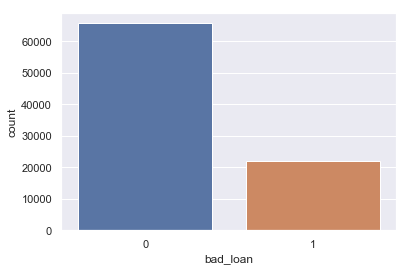

In [35]:
bad = df['bad_loan']
sns.countplot(bad)
bad_temp = df['bad_loan'].value_counts()
print(bad_temp,
      '\nbaseline: {:.4f}\n'.format(bad_temp[0] / (bad_temp[0] + bad_temp[1])),
      '\n', df['bad_loan'].value_counts(normalize=True))

In [10]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70338, 41), (70338,), (17585, 41), (17585,))

# Random Forest tuning
I am tuning the following features and I will apply adaboost to the tuned model. The model will run a 3 fold cross validation.

    - 'max_depth'
    - 'min_samples_leaf'
    - 'n_estimators'
    - 'max_features'
    - 'min_samples_split'

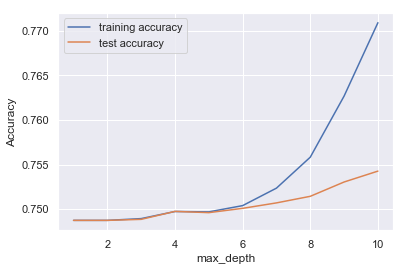

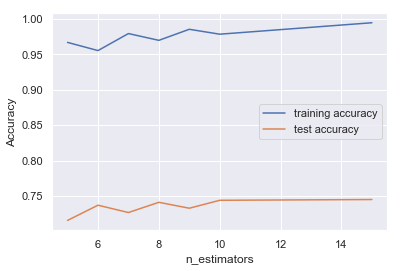

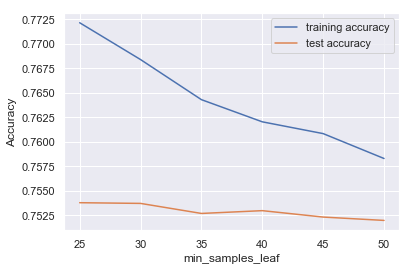

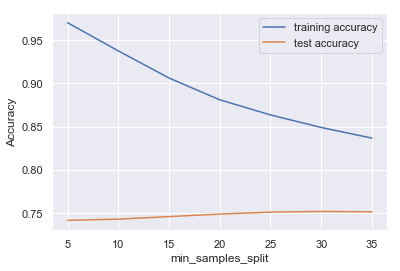

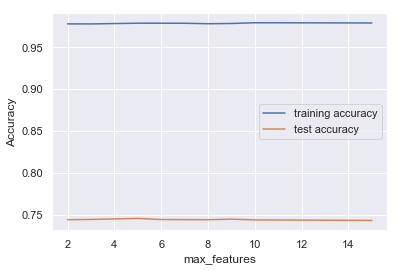

--- 164.7276 seconds --- 


In [14]:
# parameters to build the model on

start_time = time.time()

hyperparameter = ['max_depth',
                  'n_estimators',
                  'min_samples_leaf',
                  'min_samples_split',
                  'max_features']

range = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [5, 6, 7, 8, 9, 10, 15],
    [25, 30, 35, 40, 45, 50],
    [5, 10, 15, 20, 25, 30, 35],
    [2, 3, 5, 6, 7, 8, 9, 10, 15]
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    rf = ensemble.RandomForestClassifier()

    # fit tree on training data
    rfgrid = GridSearchCV(rf, parameters,
                          cv=3,
                          scoring="accuracy")
    rfgrid.fit(X_train, y_train)
    scores = rfgrid.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___Using the parameters above to fine tune to find the best model___

In [15]:
# Create the parameter grid based on the results of random search

param_grid = {
    'max_depth': [6, 15],
    'n_estimators': [14, 18],
    'min_samples_leaf': [5, 10, 20],
    'min_samples_split': [2, 5, 8],
    'max_features': [6, 8, 10]
}
# Create a based model
rf_tree = ensemble.RandomForestClassifier()
# Instantiate the grid search model
rfgrid_search = GridSearchCV(estimator=rf_tree,
                             param_grid=param_grid,
                             cv=3, n_jobs=-1, verbose=1)

In [17]:
# Fit the grid search to the data
start_time = time.time()
rfgrid_search.fit(X_train, y_train)

stop = timeit.default_timer()
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  4.4min finished


--- 270.7987 seconds --- 


In [18]:
# printing the optimal accuracy score and hyperparameters
print('The best RFC accuracy score is {0:.4f}'.format(
    rfgrid_search.best_score_),
    'and has the parameters\n', rfgrid_search.best_params_)

The best RFC accuracy score is 0.7567 and has the parameters
 {'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 18}


In [19]:
# model with the best hyperparameters
rf_final = ensemble.RandomForestClassifier(bootstrap=True,
                                           max_depth=15,
                                           max_features=10,
                                           min_samples_leaf=10,
                                           min_samples_split=2,
                                           n_estimators=18)

# Random Forest Results
Tuned RFC has an accuracy score of `75.67%` which is better than the baseline `74.83%` but by only `0.84%`

------ 

### Random Forest Features

In [ ]:
feats = {}  # a dict to hold feature_name: feature_importance
rf_final.fit(X_train, y_train)
for feature, importance in zip(X.columns, rf_final.feature_importances_):
    feats[feature] = importance

importances_rf = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
importances_rf.sort_values(by='Gini-importance',
                           ascending=False).head(41).plot(kind='bar',
                                                          rot=90,
                                                          figsize=(20, 10))

The top 10 features to be used in unsupervised clustering

In [21]:
importances_rf.sort_values(by='Gini-importance',
                           ascending=False).head(10)

,Gini-importance
loan_amnt,0.092057
tot_hi_cred_lim,0.085793
dti,0.055833
mo_sin_old_rev_tl_op,0.043277
annual_inc,0.040826
revol_util,0.040710
max_bal_bc,0.038203
all_util,0.036708
emp_title,0.036590
mo_sin_old_il_acct,0.036367


-----

# AdaBoostClassifier tuning

In [31]:
# adaboost with the RF tree as base estimator
start_time = time.time()
estimators = np.arange(1, 10, 1)

ada_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(base_estimator=rf_final,
                             n_estimators=n_est)

    res = cross_val_score(ABC,
                          X_train,
                          y_train,
                          cv=3)

    print("\nThe average accuracy score: {0:.4f}".format(np.mean(res)), n_est)
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))


The average accuracy score: 0.7564 1

The average accuracy score: 0.7561 2

The average accuracy score: 0.7584 3

The average accuracy score: 0.7581 4

The average accuracy score: 0.7587 5

The average accuracy score: 0.7569 6

The average accuracy score: 0.7597 7

The average accuracy score: 0.7584 8

The average accuracy score: 0.7578 9
--- 478.3960 seconds --- 


In [23]:
ada_final = AdaBoostClassifier(base_estimator=rf_final,
                               n_estimators=7)

##### ADABoost Results
Tuned ADABoost with n_estimator of `7`has an accuracy score of `75.97%` which is better than the baseline `74.83%` but by only `1.14%` and `0.3%` better than Random Forest.

------ 

## ADABoost Features

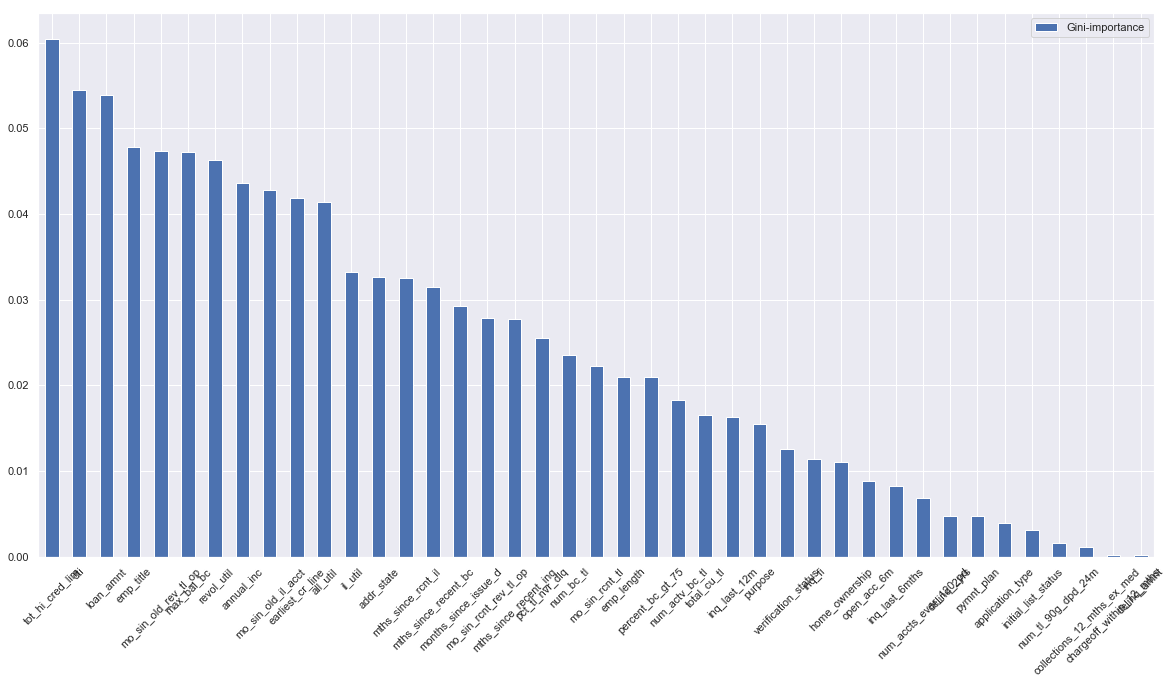

In [24]:
feats = {}  # a dict to hold feature_name: feature_importance
ada_final.fit(X_train, y_train)
for feature, importance in zip(X.columns, ada_final.feature_importances_):
    feats[feature] = importance

ada_importances = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
ada_importances.sort_values(by='Gini-importance',
                            ascending=False).head(41).plot(kind='bar',
                                                           rot=45,
                                                           figsize=(20, 10))

In [25]:
ada_importances.sort_values(by='Gini-importance',
                            ascending=False).head(10)

,Gini-importance
tot_hi_cred_lim,0.060437
dti,0.054409
loan_amnt,0.053918
emp_title,0.047863
mo_sin_old_rev_tl_op,0.047331
max_bal_bc,0.047278
revol_util,0.046267
annual_inc,0.043598
mo_sin_old_il_acct,0.042839
earliest_cr_line,0.041825


_Feature importance of the boosted Random Forest.  Past medical expenses and open accounts are big factors in getting approved for a loan._

-------------

# XGB Boost Tuning

I am tuning the following features to get the best score
    - 'max_depth'
    - 'learning_rate'
    - 'n_estimators'
    - 'subsample'
    - 'colsample_bytree'
    - 'colsample_bylevel'

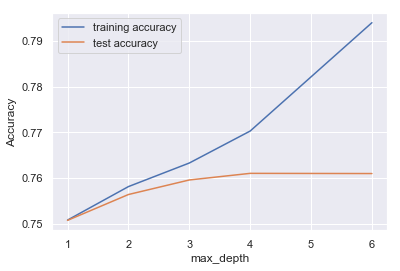

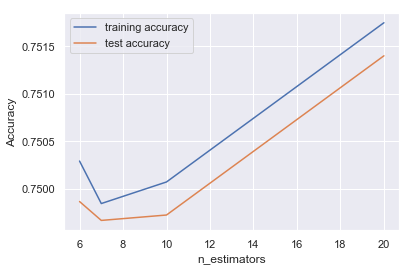

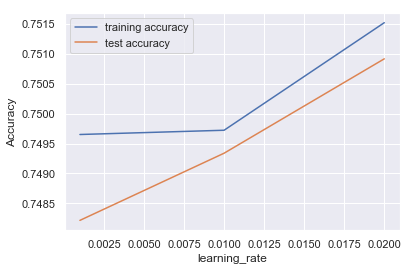

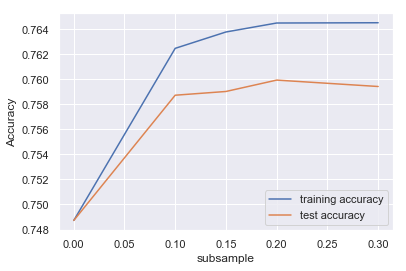

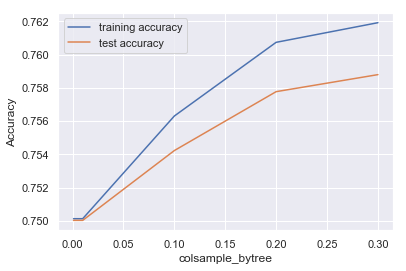

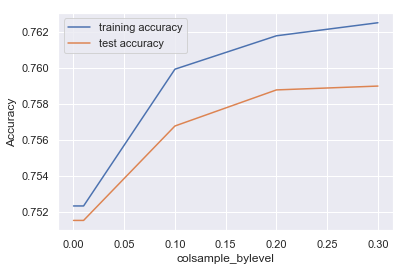

--- 620.5868 seconds --- 


In [26]:
start_time = time.time()


# parameters to build the model on
hyperparameter = ['max_depth',
                  'n_estimators',
                  'learning_rate',
                  'subsample',
                  'colsample_bytree',
                  'colsample_bylevel']

range = [
    [1, 2, 3, 4, 6],
    [6, 7, 10, 20],
    [0.001, 0.01, 0.02],
    [0.0001, 0.1, 0.15, 0.2, 0.3],
    [0.001, 0.01, 0.1, 0.2, 0.3],
    [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    XGB = XGBClassifier()

    # fit tree on training data
    XGB = GridSearchCV(XGB, parameters,
                       cv=3,
                       scoring="accuracy")  # you can change scoring functions right here.
    XGB.fit(X_train, y_train)
    scores = XGB.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___now let's plug in the values to get the final parameters___

In [27]:
param_grid = {
    'max_depth': [6, 10, 12],
    'n_estimators': [5, 10, 20],
    'learning_rate': [0.01, 0.02, 0.03],
    'subsample': [0.1, 0.02],
    'colsample_bytree': [0.03, 0.5, 0.3],
    'colsample_bylevel': [0.1, 0.3, 0.5]}
# Create a based model
xgb = XGBClassifier()
# Instantiate the grid search model
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                        cv=3, n_jobs=-1, verbose=1)

In [29]:
# Fit the grid search to the data
start_time = time.time()
xgb_grid.fit(X_train, y_train)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1458 out of 1458 | elapsed: 12.2min finished


--- 734.3605 seconds --- 


In [30]:
# printing the optimal accuracy score and hyperparameters
print('The best XGB accuracy score is {0:.4f}'.format(
    xgb_grid.best_score_), 'with parameters\n', xgb_grid.best_params_)

The best XGB accuracy score is 0.7511 with parameters
 {'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 12, 'n_estimators': 20, 'subsample': 0.1}


In [ ]:
xgb_param_grid = {
    'max_depth': [12],
    'n_estimators': [20],
    'learning_rate': [0.03],
    'subsample': [0.1],
    'colsample_bytree': [0.5],
    'colsample_bylevel': [0.5]}
xgb_final = XGBClassifier()

xgb_grid_f = GridSearchCV(estimator=xgb_final, param_grid=xgb_param_grid,
                          cv=3, n_jobs=-1, verbose=1)
xgb_grid_f.fit(X_train, y_train)
print('We can get accuracy of {0:.4f}'.format(
    xgb_grid_f.best_score_), 'with parameters\n', xgb_grid_f.best_params_)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

# XGB Results

The accuracy score for XGBoost: `75.11%` which is `0.28%` better than the baseline `74.83%`.

-----

## XBG Features

In [ ]:
xgb.fit(X_train, y_train)
xgb_fea_imp = pd.DataFrame(list(xgb.get_booster().get_fscore().items()),
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)
print('', xgb_fea_imp)

In [ ]:
fig = plt.figure(figsize=(8, 10))
feature_importance = xgb.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

-----

# Conclusion of Results

So ADABoost had the better score`76.14` for predicting good loans.

`1.31%` better than the baseline`(74.83%)`

`1.34%` better than XGBoost`(74.87%)`

`0.89%` better than Random Forest`(75.25%)`


76.14% of the time the ADABoost model is able to predict whether a loan is good. XGB barely beats the baseline. Now I will use the tuned values to compare the accuracy of all the models.  Looking at the features, there are more that can clearly be removed before modeling as they don't add value to the model.